In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.image as mpimg


2025-03-17 11:36:10.114186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('Melamoma_Classifier/datasets/ISIC_2020_Training_GroundTruth.csv')
df_test = pd.read_csv('Melamoma_Classifier/datasets/ISIC_2020_Test_Metadata.csv')

In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Encode "Sex" column
df["sex"] = encoder.fit_transform(df["sex"])

                 sex  age_approx    target
sex         1.000000    0.109827  0.027604
age_approx  0.109827    1.000000  0.086388
target      0.027604    0.086388  1.000000


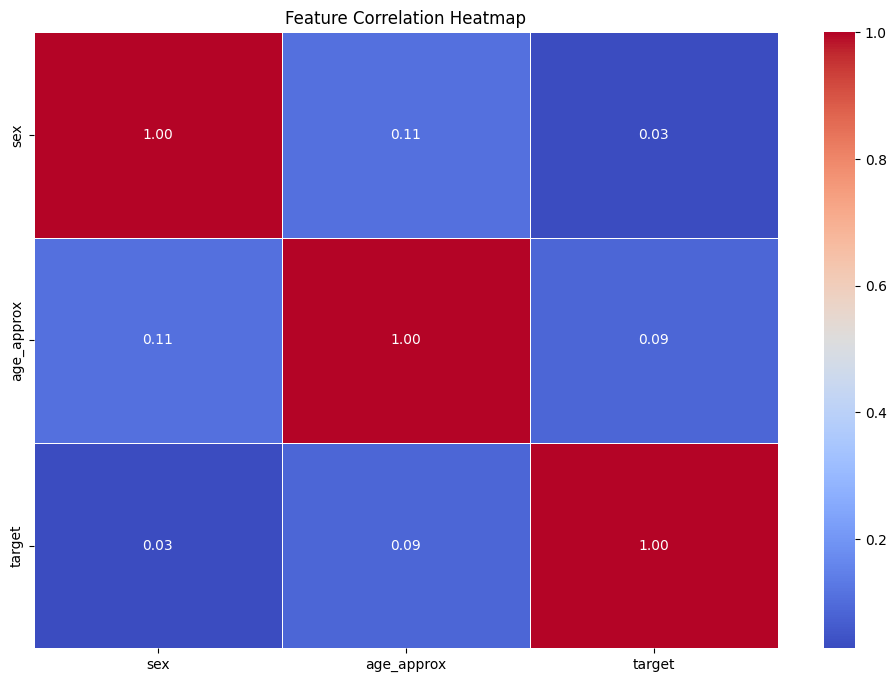

In [26]:
import seaborn as sns
numeric_df = df.select_dtypes(include=["number"])
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

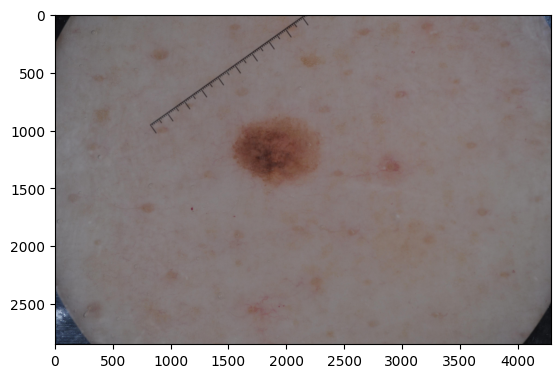

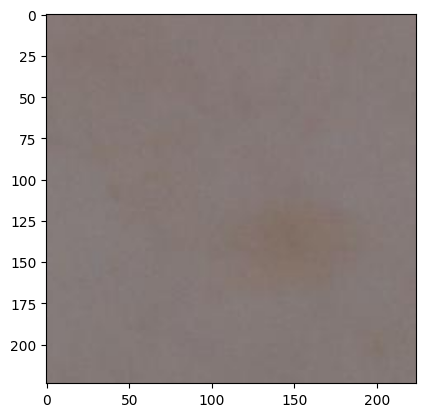

In [6]:
image=mpimg.imread('Melamoma_Classifier/datasets/train/ISIC_0232101.jpg')
image_after = tf.image.random_crop(image, size=[224, 224, 3]) 
plt.imshow(image)
plt.show()
plt.imshow(image_after)
plt.show()

In [4]:
X = df['image_name'].tolist()
y = df['target'].tolist()

X_test = df_test['image'].tolist()

In [28]:
#Here I will preprocess the image by resizing it to 256 . It is hardly possible to do it on the fly:

import cv2
from tqdm import tqdm


input_folder = "Melamoma_Classifier/datasets/train/"
output_folder = "Melamoma_Classifier/datasets/preprocessed_images/train"

os.makedirs(output_folder, exist_ok=True)

for filename in tqdm(os.listdir(input_folder)):
    img = cv2.imread(os.path.join(input_folder, filename))
    img = cv2.resize(img, (256, 256))
    
    cv2.imwrite(os.path.join(output_folder, filename), img)

100%|██████████| 33126/33126 [1:00:18<00:00,  9.15it/s]


In [ ]:
input_folder = "Melamoma_Classifier/datasets/test/"
output_folder = "Melamoma_Classifier/datasets/preprocessed_images/test"

os.makedirs(output_folder, exist_ok=True)
n_files = 0
for filename in tqdm(os.listdir(input_folder)):
    img = cv2.imread(os.path.join(input_folder, filename))
    img = cv2.resize(img, (256, 256))
    
    
    cv2.imwrite(os.path.join(output_folder, filename), img)
    n_files+=1

print(n_files)

100%|██████████| 10982/10982 [22:02<00:00,  8.30it/s] 


In [18]:
#Make the function which will resize the image, normilize it and if needed augment the truh lables whtre the target is 1
IMG_SIZE = 256
BATCH_SIZE = 32
@tf.function
def load_image(path, image_name, label=None, augment=True, train=True):
  path = tf.convert_to_tensor(path, dtype=tf.string)
  image_name = tf.strings.join([image_name,".jpg"])
  img_path = tf.strings.join([path, image_name])
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  if augment and train:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.rot90(image, k=1)

  #Resize
  image = image / 255.0
  

  return (image, label) if train else image 

In [19]:
images_train = tf.convert_to_tensor("Melamoma_Classifier/datasets//train/", dtype=tf.string) 
for i in X[:2]:
    load_image(images_train, i, y[X.index(i)], augment=False, train=True)

In [20]:
# Define the correct path to images and convert to Tensor
images_train = tf.convert_to_tensor("Melamoma_Classifier/datasets/train/", dtype=tf.string) 
images_test = tf.convert_to_tensor("Melamoma_Classifier/datasets/test/", dtype=tf.string) 

dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.map(lambda x, y: load_image(images_train, x, y, augment=False, train=True))
dataset = dataset.shuffle(len(X)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 

train_size = int(0.8 * len(X_test))
dataset_train = dataset.take(train_size)
dataset_valid = dataset.skip(train_size)


dataset_test = tf.data.Dataset.from_tensor_slices((X_test))
dataset_test = dataset_test.map(lambda x: load_image(images_test, x, augment=False, train=False))
dataset_test = dataset_test.shuffle(len(X_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 



In [ ]:
# Check dataset structure
for image, label in dataset.take(5):  # Show first 5 samples
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

2025-03-17 11:30:49.563351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 573 of 33126
2025-03-17 11:30:59.854667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1036 of 33126
2025-03-17 11:31:19.538470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1694 of 33126
2025-03-17 11:31:30.178090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1886 of 33126
2025-03-17 11:31:49.728712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2240 of 33126


In [ ]:
#We have devided the datasets